# **Chapter 5 합성곱 신경망I**

### **[개념 정리]**

#### **5.3 전이 학습**

전이 학습(transfer learning)
> 매우 큰 데이터셋을 사용하여 훈련된 모델의 가중치를 가져와 우리가 해결하려는 과제에 맞게 보정하여 사용하는 것

##### **5.3.1 특성 추출 기법**

특성 추출(feature extractor)
> ImageNet 데이터셋으로 사전 훈련된 모델을 가져온 후 마지막에 완전연결층 부분만 새로 만듦
> - 즉, 학습할 때 마지막 완전연결층(이미지의 카테고리를 결정하는 부분)만 학습하고 나머지 계층은 학습 X

1. 합성곱층
  - 합성곱층과 풀링층으로 구성
2. 데이터 분류기(완전연결층)
  - 추출된 특성을 입력받아 최종적으로 이미지에 대한 클래스를 분류하는 부분

##### **5.3.2 미세 조정 기법**

미세 조정(fine-tuning)
> 특성 추출 기법에서 더 나아가 사전 훈련된 모델과 합성곱층, 데이터 분류기의 가중치를 업데이트하여 훈련시키는 방식
> 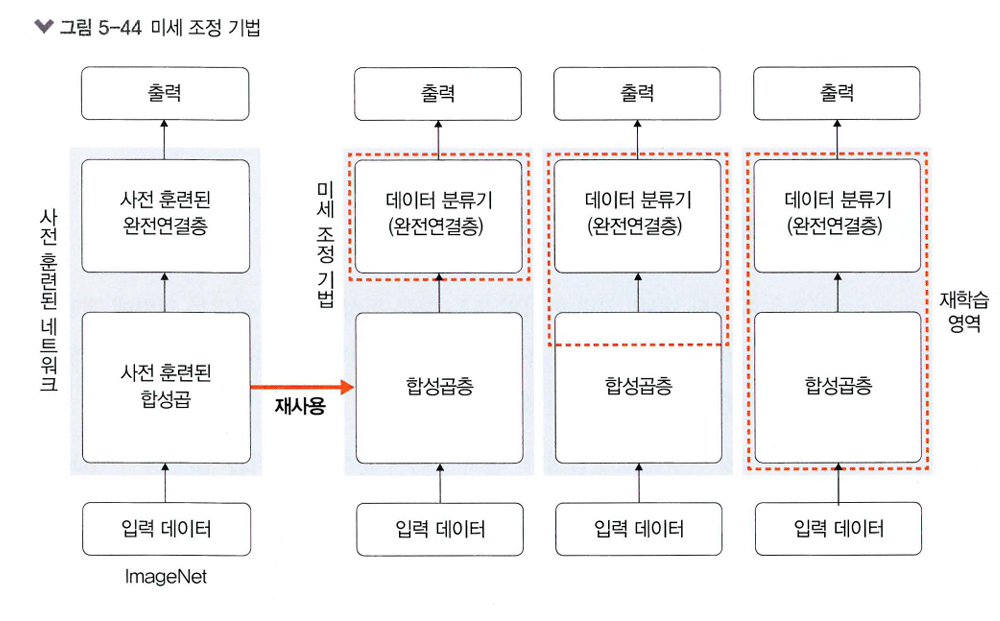

### **[필사]**

In [ ]:
!pip install opencv-python

In [ ]:
import os
import time
import copy
import glob
import cv2
import shutil

import torch
import torchvision
import torchvision.transforms as transforms
import torchvision.models as models
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader

import matplotlib.pyplot as plt

In [ ]:
!git clone https://github.com/gilbutITbook/080289.git

Cloning into '080289'...
remote: Enumerating objects: 2278, done.
remote: Counting objects: 100% (32/32), done.
remote: Compressing objects: 100% (29/29), done.
remote: Total 2278 (delta 4), reused 27 (delta 3), pack-reused 2246 (from 1)
Receiving objects: 100% (2278/2278), 330.30 MiB | 42.83 MiB/s, done.
Resolving deltas: 100% (13/13), done.
Updating files: 100% (2591/2591), done.


In [ ]:
data_path = './080289/chap05/data/catanddog/train/'
transform = transforms.Compose(
    [transforms.Resize([256,256]),
     transforms.RandomResizedCrop(224),
     transforms.RandomHorizontalFlip(),
     transforms.ToTensor()]
)
train_dataset = torchvision.datasets.ImageFolder(
    data_path,
    transform = transform
)
train_loader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=32,
    num_workers=8,
    shuffle=True
)
print(len(train_dataset))

385


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


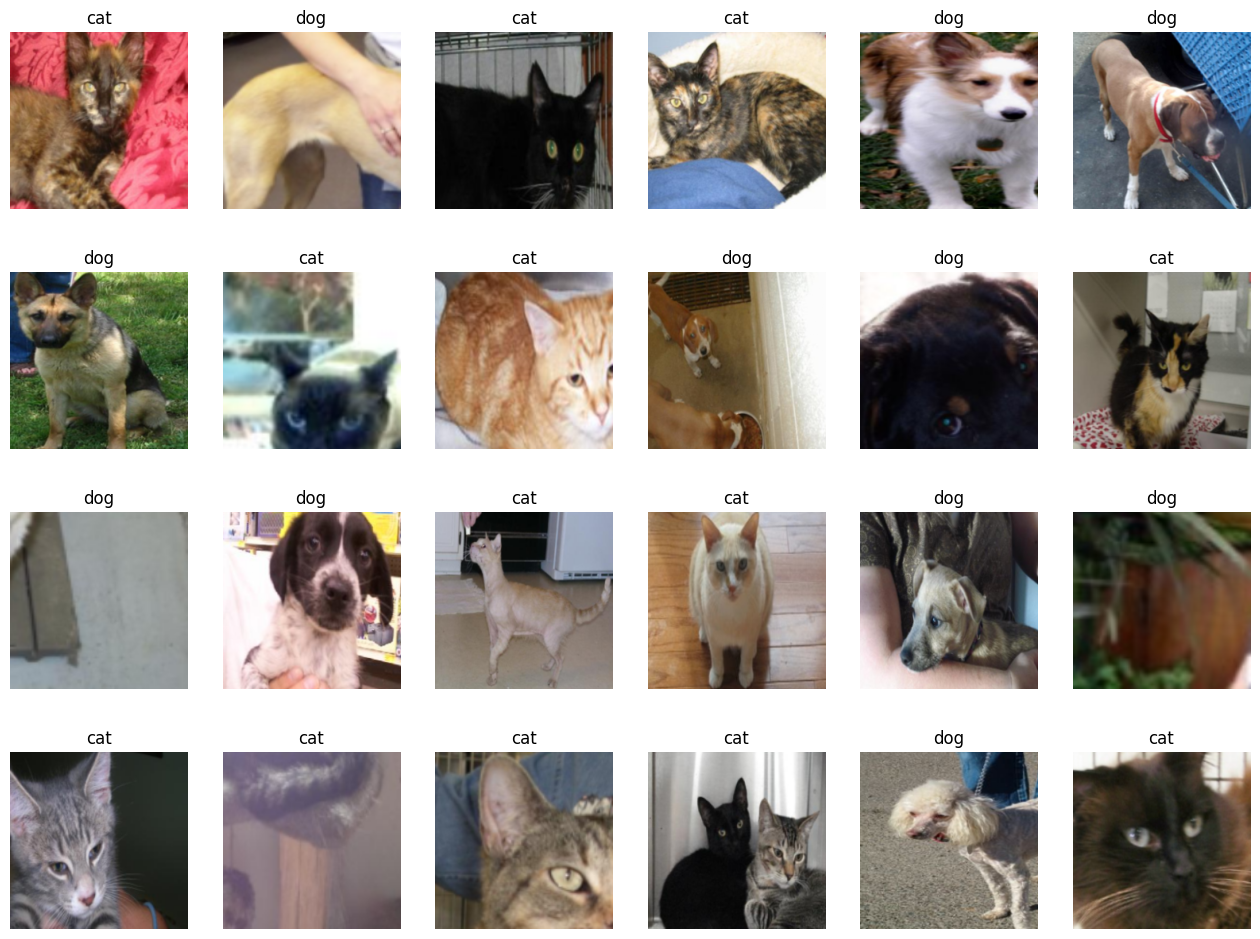

In [ ]:
import numpy as np
samples, labels = next(iter(train_loader))
classes = {0:'cat', 1:'dog'}
fig = plt.figure(figsize=(16,24))
for i in range(24):
  a = fig.add_subplot(4, 6, i+1)
  a.set_title(classes[labels[i].item()])
  a.axis('off')
  a.imshow(np.transpose(samples[i].numpy(), (1,2,0)))
plt.subplots_adjust(bottom=0.2, top=0.6, hspace=0)

In [ ]:
resnet18 = models.resnet18(pretrained=True)

In [ ]:
def set_parameter_requires_grad(model, feature_extracting=True):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False

set_parameter_requires_grad(resnet18)

In [ ]:
resnet18.fc = nn.Linear(512,2)

In [ ]:
for name, param in resnet18.named_parameters():
  if param.requires_grad:
    print(name, param.data)

fc.weight tensor([[-0.0015,  0.0359, -0.0207,  ...,  0.0401,  0.0174,  0.0393],
        [-0.0178, -0.0396, -0.0402,  ...,  0.0372, -0.0245, -0.0113]])
fc.bias tensor([ 0.0100, -0.0078])


In [ ]:
model = models.resnet18(pretrained = True)

for param in model.parameters():
    param.requires_grad = False

model.fc = torch.nn.Linear(512, 2)
for param in model.fc.parameters():
    param.requires_grad = True

optimizer = torch.optim.Adam(model.fc.parameters())
cost = torch.nn.CrossEntropyLoss()
print(model)

/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [ ]:
def train_model(model, dataloaders, criterion, optimizer, device, num_epochs=13, is_train=True):
    since = time.time()
    acc_history = []
    loss_history = []
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        running_loss = 0.0
        running_corrects = 0

        for inputs, labels in dataloaders:
            inputs = inputs.to(device)
            labels = labels.to(device)

            model.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            _, preds = torch.max(outputs, 1)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

        epoch_loss = running_loss / len(dataloaders.dataset)
        epoch_acc = running_corrects.double() / len(dataloaders.dataset)

        print('Loss: {:.4f} Acc: {:.4f}'.format(epoch_loss, epoch_acc))

        if epoch_acc > best_acc:
            best_acc = epoch_acc

        acc_history.append(epoch_acc.item())
        loss_history.append(epoch_loss)
        torch.save(model.state_dict(), os.path.join('./080289/chap05/data/catanddog/', '{0:0=2d}.pth'.format(epoch)))
        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best Acc: {:4f}'.format(best_acc))
    return acc_history, loss_history

In [ ]:
params_to_update = []
for name,param in resnet18.named_parameters():
    if param.requires_grad == True:
        params_to_update.append(param)
        print("\t",name)

optimizer = optim.Adam(params_to_update)

	 fc.weight
	 fc.bias


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
criterion = nn.CrossEntropyLoss()
train_acc_hist, train_loss_hist = train_model(resnet18, train_loader, criterion, optimizer, device)

Epoch 0/12
----------


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Loss: 0.5500 Acc: 0.7377

Epoch 1/12
----------
Loss: 0.3528 Acc: 0.8701

Epoch 2/12
----------
Loss: 0.2985 Acc: 0.8883

Epoch 3/12
----------
Loss: 0.2861 Acc: 0.8909

Epoch 4/12
----------
Loss: 0.2215 Acc: 0.9247

Epoch 5/12
----------
Loss: 0.2240 Acc: 0.9273

Epoch 6/12
----------
Loss: 0.2351 Acc: 0.9117

Epoch 7/12
----------
Loss: 0.2757 Acc: 0.8753

Epoch 8/12
----------
Loss: 0.1849 Acc: 0.9351

Epoch 9/12
----------
Loss: 0.1794 Acc: 0.9429

Epoch 10/12
----------
Loss: 0.1747 Acc: 0.9299

Epoch 11/12
----------
Loss: 0.1815 Acc: 0.9299

Epoch 12/12
----------
Loss: 0.2063 Acc: 0.9039

Training complete in 0m 35s
Best Acc: 0.942857


In [ ]:
test_path = './080289/chap05/data/catanddog/test/'

transform = transforms.Compose(
                [
                    transforms.Resize(224),
                    transforms.CenterCrop(224),
                    transforms.ToTensor(),
                ])
test_dataset = torchvision.datasets.ImageFolder(
    root=test_path,
    transform=transform
)
test_loader = torch.utils.data.DataLoader(
    test_dataset,
    batch_size=32,
    num_workers=1,
    shuffle=True
)

print(len(test_dataset))

98


In [ ]:
def eval_model(model, dataloaders, device):
    since = time.time()
    acc_history = []
    best_acc = 0.0

    saved_models = glob.glob('./080289/chap05/data/catanddog/' + '*.pth')
    saved_models.sort()
    print('saved_model', saved_models)

    for model_path in saved_models:
        print('Loading model', model_path)

        model.load_state_dict(torch.load(model_path))
        model.eval()
        model.to(device)
        running_corrects = 0

        for inputs, labels in dataloaders:
            inputs = inputs.to(device)
            labels = labels.to(device)

            with torch.no_grad():
                outputs = model(inputs)

            _, preds = torch.max(outputs.data, 1)

            running_corrects += preds.eq(labels).int().sum()

        epoch_acc = running_corrects.double() / len(dataloaders.dataset)
        print('Acc: {:.4f}'.format(epoch_acc))

        if epoch_acc > best_acc:
            best_acc = epoch_acc

        acc_history.append(epoch_acc.item())
        print()

    time_elapsed = time.time() - since
    print('Validation complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best Acc: {:4f}'.format(best_acc))

    return acc_history

In [ ]:
val_acc_hist = eval_model(resnet18, test_loader, device)

saved_model ['./080289/chap05/data/catanddog/00.pth', './080289/chap05/data/catanddog/01.pth', './080289/chap05/data/catanddog/02.pth', './080289/chap05/data/catanddog/03.pth', './080289/chap05/data/catanddog/04.pth', './080289/chap05/data/catanddog/05.pth', './080289/chap05/data/catanddog/06.pth', './080289/chap05/data/catanddog/07.pth', './080289/chap05/data/catanddog/08.pth', './080289/chap05/data/catanddog/09.pth', './080289/chap05/data/catanddog/10.pth', './080289/chap05/data/catanddog/11.pth', './080289/chap05/data/catanddog/12.pth']
Loading model ./080289/chap05/data/catanddog/00.pth
Acc: 0.9082

Loading model ./080289/chap05/data/catanddog/01.pth
Acc: 0.9592

Loading model ./080289/chap05/data/catanddog/02.pth
Acc: 0.9490

Loading model ./080289/chap05/data/catanddog/03.pth
Acc: 0.9490

Loading model ./080289/chap05/data/catanddog/04.pth
Acc: 0.9490

Loading model ./080289/chap05/data/catanddog/05.pth
Acc: 0.9490

Loading model ./080289/chap05/data/catanddog/06.pth
Acc: 0.9592


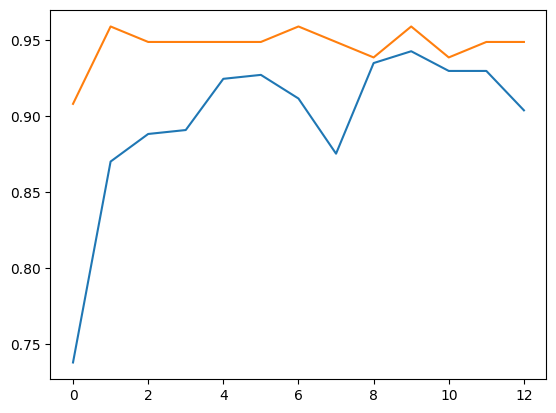

In [ ]:
plt.plot(train_acc_hist)
plt.plot(val_acc_hist)
plt.show()

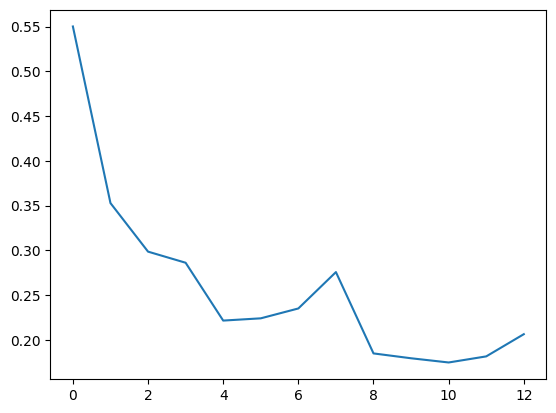

In [ ]:
plt.plot(train_loss_hist)
plt.show()



---



In [ ]:
def im_convert(tensor):
    image=tensor.clone().detach().numpy()
    image=image.transpose(1,2,0)
    image=image*(np.array((0.5,0.5,0.5))+np.array((0.5,0.5,0.5)))
    image=image.clip(0,1)
    return image

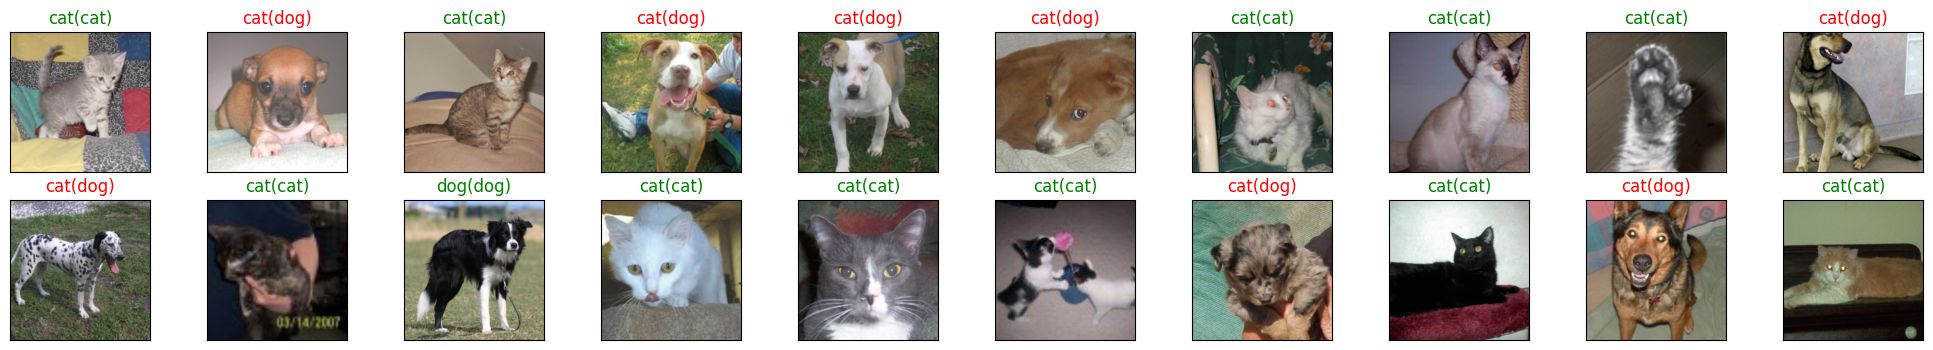

<Figure size 640x480 with 0 Axes>

In [ ]:
classes = {0:'cat', 1:'dog'}

dataiter=iter(test_loader)
images,labels= next(dataiter)
output=model(images)
_,preds=torch.max(output,1)

fig=plt.figure(figsize=(25,4))
for idx in np.arange(20):
    ax=fig.add_subplot(2,10,idx+1,xticks=[],yticks=[])
    plt.imshow(im_convert(images[idx]))
    a.set_title(classes[labels[i].item()])
    ax.set_title("{}({})".format(str(classes[preds[idx].item()]),str(classes[labels[idx].item()])),color=("green" if preds[idx]==labels[idx] else "red"))
plt.show()
plt.subplots_adjust(bottom=0.2, top=0.6, hspace=0)